In [30]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [31]:

runners = pd.read_csv('results.csv')

In [32]:
runners.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [33]:
runners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


In [34]:
runners.isnull().sum()*100/len(runners)

25k           0.000000
age           0.000000
name          0.000000
division      0.000000
10k           0.000000
gender        0.000000
half          0.000000
official      0.000000
bib           0.000000
ctz          95.316753
country       0.000000
overall       0.000000
pace          0.000000
state         9.050977
30k           0.000000
5k            0.000000
genderdiv     0.000000
20k           0.000000
35k           0.000000
city          0.006187
40k           0.000000
dtype: float64

In [35]:
runners.state.fillna(('Unknown'),inplace=True)

In [36]:
runners.drop(('ctz'),axis=1, inplace=True)

In [37]:
runners['city'].fillna(runners['city'].mode()[0], inplace=True)
runners = runners.replace(to_replace='-', value='0')

In [38]:

runners['gender'] = np.where(runners['gender']=='F', 1, 0)

In [39]:
columns= runners[['5k', '10k','20k', '25k','30k','35k', '40k', 'official', 'overall']]

In [40]:
for column in columns:
    runners[column] = pd.to_numeric(runners[column], errors='coerce')

runners = runners.dropna()

In [48]:
#splitting data for better run time
from sklearn.model_selection import train_test_split
df1, df2 = train_test_split(runners, test_size=0.90, random_state=42)
X = df1.loc[:, ['5k',
                       '10k',
                       '20k',
                       'half',
                       '25k',
                       '30k',
                       '35k',
                       '40k',
                       'official'
                       ]]
X_norm = normalize(X)

### K means 

In [50]:
wcss= []
for i in np.arange(2,10,1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init= 10, random_state=42)
    kmeans.fit(X_norm)
    labels = kmeans.labels_
    silhouette = metrics.silhouette_score(X_norm,labels=labels, metric='euclidean')
    wcss.append(kmeans.inertia_)
    print('K: {}, silhouette: {}'.format(i, silhouette))

K: 2, silhouette: 0.9782849869042791
K: 3, silhouette: 0.6241892528991614
K: 4, silhouette: 0.6282839786406883
K: 5, silhouette: 0.6122855208635076
K: 6, silhouette: 0.6119567337823534
K: 7, silhouette: 0.47926959065857627
K: 8, silhouette: 0.48467187593624467
K: 9, silhouette: 0.43439959244902115


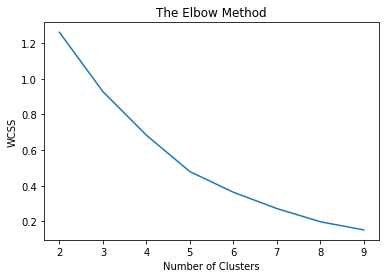

In [51]:
plt.plot(np.arange(2,10,1), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [52]:
kmeans = KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init= 10, random_state=42)
y_kmeans= kmeans.fit_predict(X_norm)

### Mean Shift

In [21]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Set bandwidth estimator
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Get labels, number of clusters, similarity score
labels = ms.labels_
n_clusters = len(np.unique(labels))
silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
print('K: {}, silhouette: {}'.format(n_clusters, silhouette))

K: 119, silhouette: 0.15808572817557895


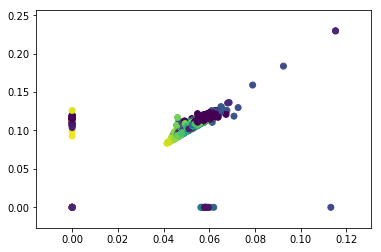

In [22]:
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=labels)
plt.show()

### K means with PCA

In [63]:
X = runners.loc[:, ['5k',
                       '10k',
                       '20k',
                       'half',
                       '25k',
                       '30k',
                       '35k',
                       '40k',
                       'official'
                       ]]
X_norm = normalize(X)

In [64]:


pca = PCA(n_components=2)
pca_X = pca.fit(X_norm).transform(X_norm)

# Get cluster assignments with k=2
model = KMeans(n_clusters=2, random_state=42).fit(X_norm)
labels = model.labels_
runners['cluster'] = labels

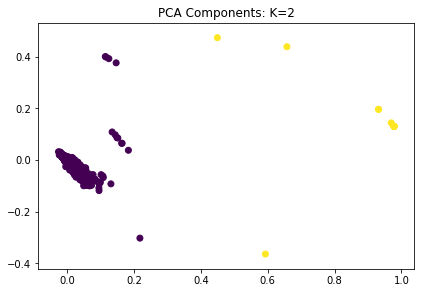

In [65]:
# Plot PCA components and clusters
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=runners['cluster'])
plt.tight_layout()
plt.title('PCA Components: K=2')
plt.show()

### Spectral Clustering

In [62]:
from sklearn.cluster import SpectralClustering

# Run spectral clustering over range of k values
for i in np.arange(2,5):
    sc = SpectralClustering(n_clusters=i, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 4, silhouette: 0.9782849869042791
K: 4, silhouette: 0.9782849869042791
K: 4, silhouette: 0.9782849869042791


### Affinity Propagation

In [53]:

from sklearn.cluster import AffinityPropagation

# Run and fit model
af = AffinityPropagation().fit(X_norm)

# Get number of clusters
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
print('K: {}'.format(n_clusters))

K: 72
